- change validation to adapt to real evaluation system
- completely change the programs of feature engineering to prevent leakage

In [1]:
import sys
import copy
import random
import feather
import warnings
import numpy as np
import pandas as pd
from time import time
import lightgbm as lgb
from collections import Counter
from sklearn import preprocessing
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 

import riiideducation
warnings.filterwarnings("ignore")

In [2]:
DIR = "../input/riiid-test-answer-prediction/"
train = pd.read_feather("../input/riid-train/train.feather")
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")

# preprocess

In [3]:
train.drop(["row_id", 'user_answer'], axis=1, inplace=True)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(value = False).astype(bool)

user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ["correct_rate_before_ans"]

user_lectures_df = train.groupby('user_id').agg({'content_id': ['sum']}).copy()
user_lectures_df.columns = ["lectures_before_ans"]

#content_answers_df = train.groupby('content_id').agg({'answered_correctly': ['mean']}).copy()
#content_answers_df.columns = ['mean_accuracy_by_content']

In [4]:
le = preprocessing.LabelEncoder()
train["prior_question_had_explanation"] = le.fit_transform(train["prior_question_had_explanation"])

In [5]:
# to get first index of a particular user
#for i in train.groupby("user_id").first().index:
#    if i > 90000000:
#        print(i)
#        break

In [6]:
train = train.iloc[90007298:,:]
train = train.sort_values(['user_id', 'timestamp'])
train['task_container_id'] = (train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16'))
train.head(10)

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
90007298,0,1911932135,4705,0,0,0,4294967295,0
90007299,10764,1911932135,4877,0,1,1,39000,0
90007300,45162,1911932135,3923,0,2,1,5000,0
90007301,77874,1911932135,3893,0,3,0,31000,0
90007302,147369,1911932135,6318,0,4,1,30000,0
90007303,178960,1911932135,4623,0,5,0,67000,0
90007304,235152,1911932135,5318,0,6,1,29000,0
90007305,270177,1911932135,8497,0,7,1,54000,0
90007306,308144,1911932135,6683,0,8,0,33000,0
90007307,327228,1911932135,4023,0,9,0,35000,0


In [7]:
train.shape, len(train.user_id.unique())

((11223034, 8), 43496)

# Feature engineering

In [8]:
def get_data(df, test_set=False):
    if test_set == False:
        df = df.loc[df['answered_correctly'] != -1].reset_index(drop=True)
        
        correct_rate = np.array([])
        lec_num = np.array([])
        for i, (ins_id, user_sample) in tqdm(enumerate(df.groupby('user_id', sort=False)), total=train.user_id.nunique(), desc='user_id', position=0):
            cum_correct_num = user_sample["answered_correctly"].cumsum().values
            cum_answer_num = [i+1 for i in range(user_sample.shape[0])]
            
            correct_rate_list = [cum_correct_num[i]/cum_answer_num[i] for i in range(len(cum_answer_num))]
            correct_rate_list = [-1] + correct_rate_list[:-1]
            correct_rate = np.concatenate([correct_rate, correct_rate_list])
            
            lec_seq = list(user_sample["content_type_id"].cumsum().values)
            lec_list = [-1] + lec_seq[:-1]
            lec_num = np.concatenate([lec_num, lec_list])
            
        df["correct_rate_before_ans"] = correct_rate  
        df["lectures_before_ans"] = lec_num
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') # for correct_rate_before_ans
        df = df.merge(user_lectures_df, how = 'left', on = 'user_id') # for lectures_before_ans
        #df = df.merge(content_answers_df, how = 'left', on = 'content_id')

    # https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names
    df = df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    df.drop(["timestamp", "question_id"], axis=1, inplace=True)
    df.fillna(value = -1, inplace = True)
    return df
train = get_data(train)

In [9]:
target = 'answered_correctly'
columns = ["correct_rate_before_ans", "lectures_before_ans", 'content_id', 'task_container_id', 'part'] 
#'prior_question_had_explanation', 'prior_question_elapsed_time', 'mean_accuracy_by_content'

drop_columns = [i for i in train.columns if i not in columns + [target] + ["user_id"]] 
train.drop(drop_columns, axis=1, inplace=True)

In [10]:
train.head()

,user_id,content_id,task_container_id,answered_correctly,correct_rate_before_ans,lectures_before_ans,part
0,1911932135,4705,0,0,-1.000000,-1.0,5
1,1911932135,4877,1,1,0.000000,0.0,5
2,1911932135,3923,2,1,0.500000,0.0,5
3,1911932135,3893,3,0,0.666667,0.0,5
4,1911932135,6318,4,1,0.500000,0.0,5


# modelling

In [11]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [12]:
categoricals = ["content_id", "part"]
params = {'objective': 'binary', "metric": 'auc','eval_metric':'auc', 'boosting_type': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.01, 
               "num_leaves": 50, 'random_seed':44, 'max_depth': 10} 
n_folds=5

def modelling_lgb(X_train, y_train):
    groups = np.array(X_train.user_id.values)
    
    models = []
    valid = np.array([])
    real = np.array([])
    #valid = np.zeros([X_train.shape[0]])
        
    features_list = [i for i in X_train.columns if i != "user_id"]
    feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
    
    for i , (train_index, test_index) in enumerate(stratified_group_k_fold(X_train, y_train, groups, k=n_folds, seed=0)):
        print("Fold {}".format(i+1))
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]
        X_train2.drop("user_id", axis=1, inplace=True)

        X_valid2 = X_train.iloc[test_index,:]
        
        # https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
        max_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(max) == X_valid2['task_container_id']
        min_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(min) == X_valid2['task_container_id']
        X_valid2 = X_valid2[max_idx|min_idx]
        
        y_valid2 = y_train.iloc[test_index]
        y_valid2 = y_valid2[max_idx|min_idx]
        X_valid2.drop("user_id", axis=1, inplace=True)

        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=200,early_stopping_rounds=10,verbose_eval = 10, categorical_feature=categoricals) 
        feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        
        valid = np.concatenate([valid, valid_predict])
        real = np.concatenate([real, y_valid2])
        #valid[test_index] = valid_predict
        
        models.append(clf) 
        
    feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]
    feature_importance_df = feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True)
            
    score = roc_auc_score(real, valid) #y_valid
    print("Overall ROC AUC: ", score)
        
    return models, feature_importance_df
models, feature_importance_df = modelling_lgb(train[columns + ["user_id"]], train[target])

Fold 1
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.674395	valid_1's auc: 0.701138
Early stopping, best iteration is:
[6]	training's auc: 0.670791	valid_1's auc: 0.702173
Fold 2
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.67621	valid_1's auc: 0.699281
Early stopping, best iteration is:
[6]	training's auc: 0.673075	valid_1's auc: 0.703625
Fold 3
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.676657	valid_1's auc: 0.696562
[20]	training's auc: 0.680578	valid_1's auc: 0.696498
Early stopping, best iteration is:
[14]	training's auc: 0.677722	valid_1's auc: 0.697542
Fold 4
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.676347	valid_1's auc: 0.701001
[20]	training's auc: 0.680045	valid_1's auc: 0.701235
Early stopping, best iteration is:
[14]	training's auc: 0.677954	valid_1's auc: 0.701292
Fold 5
Training until validation scores don't impro

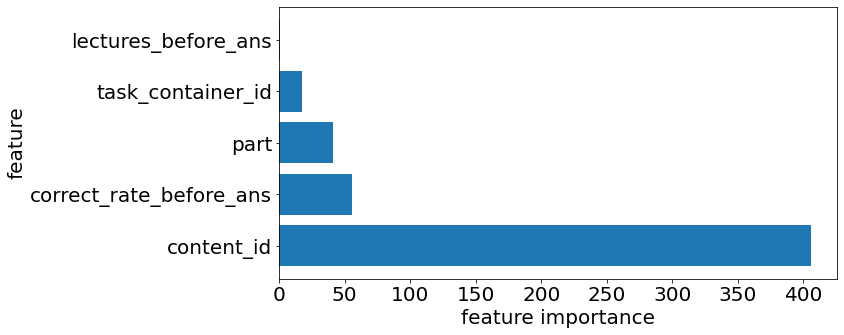

In [13]:
plt.rcParams.update({'font.size': 20})
x = list(feature_importance_df["Feature"].values)
y = feature_importance_df["Average"].values

x_position = np.arange(len(x))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_ylabel('feature')
ax.set_xlabel('feature importance')
plt.show()

# prediction

In [14]:
del train

In [15]:
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []

    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df = get_data(test_df, test_set=True)
    test_df["prior_question_had_explanation"] = le.fit_transform(test_df["prior_question_had_explanation"])

    for model in models:
        y_pred = model.predict(test_df[columns], num_iteration=model.best_iteration)
        y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])